## Index 


* [Instruction](#instruction)
* [Install](#install)
* [Load data](#loadData) 
* [Algorithm](#algorithm) 
* [Run](#run)
* [visulization](#visulization)
* [Reference/Resource](#reference)

<a id='instruction'></a>
## Instruction 

This notebook is about experiment the Gallinucci et al's algorithm. Please refer to our paper and Gallinucci et al paper for more detail. We will give useful information about how to install used package and software in Chapter Install. Please run Algorithm first before go to Run chapter. Also, Please run All cells in Run and visulization in orders to prevent errors.

<a id='install'></a>
## Install

This program is run in Jupyter Notebook. Please install Anaconda and all related packages. 

### Install Anaconda


Please refer to Anaconda offical documentation to install Anaconda https://docs.anaconda.com/anaconda/install/windows/

### Use Anaconda and jupyter notebook

When you install Anaconda, it will also install jupyter notebook. 
Lunching jupyter notebook can be done in different ways:
* You can lunch it through Anaconda Navigator (Windows).
* Lunch it by Anaconda Prompt (Windows):
    - Open Anaconda Prompt
    - Type: jupyter notebook
    - hit Enter
    - wait jupyter notebook pop up
* Lunch it by Terminal (Linux):
    - Opern Terminal
    - Type: jupyter notebook
    - hit Enter
    - wait jupyter notebook pop up

### Install packages

I reconmmend install packages through Anaconda Prompt (Windows) or Terminal(Linux). The following code cell is all packages you need to install. Please search the package name in the search bar at https://anaconda.org/. Click the correct package. You will find a command that you need to enter to install those package.
Please refer to https://github.com/cpcloud/ipython-autotime to install autotime package.

In [2]:
# Load all needed packages
%load_ext autotime
import pymongo
import json
import copy
import math
import statistics
import time
import collections
import random 
import csv
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import pprint
from graphviz import Graph
from random import shuffle

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7 ms


<a id='loadData'></a>
## Load data

In this chapter, we will provide different ways to load data. It can be loaded from MongoDB or load from loacal files. The data type that the algorithm need is a list of documents. The document should be in dictionary data structure. Since different local files has different way of storing. Therefore, there are a lot of code cells to fit different files. You do not need to run them all. Just pick the correct one.

austin_311.311_service_requests.json
schemabased1.json
schemabased2.json
valuesplit1.json
valuesplit2.json
attribute6.json
attribute8.json
attribute10.json
attribute10.json

### Load from the MongoDB

In [5]:
# create connecttion with database
# Note: to connect to your own db, change the url and port number
# Also change the authenticate
client = pymongo.MongoClient('mongodb://ds121163.mlab.com',21163)
# Get the database
jasondb = client['jasondb']
# Set authentication
jasondb.authenticate('admin','admin123')
# Get collection, if no named collection then create one
companies = jasondb.test 
# name of the output file

OUTPUT_FILE_NAME = 'output.json'


time: 380 ms


In [7]:
# get document in the collection and store them in data
data = []
for document in companies.find({}):
    data.append(document)
print(data)

[{'_id': ObjectId('5ca42234d1823d1f90e4474d'), 'rental_id': '42406939', 'duration': '4500', 'bike_id': '8519', 'end_station_name': 'Victoria Park Road, Hackney Central'}, {'_id': ObjectId('5ca42234d1823d1f90e4474e'), 'rental_id': '42954682', 'duration': '2460', 'bike_id': '19', 'end_station_name': 'Lansdowne Road, Ladbroke Grove'}, {'_id': ObjectId('5ca42234d1823d1f90e4474f'), 'rental_id': '42152586', 'duration': '3180', 'bike_id': '12438', 'end_station_name': "Bishop's Bridge Road West, Bayswater"}, {'_id': ObjectId('5ca42234d1823d1f90e44750'), 'rental_id': '43633514', 'duration': '2940', 'bike_id': '11699', 'end_station_name': 'Clapham Common North side, Clapham Common'}, {'_id': ObjectId('5ca42234d1823d1f90e44751'), 'rental_id': '40628499', 'duration': '2340', 'bike_id': '9030', 'end_station_name': 'Panton Street, West End'}, {'_id': ObjectId('5ca42234d1823d1f90e44752'), 'rental_id': '40636098', 'duration': '2940', 'bike_id': '1322', 'end_station_name': 'Silverthorne Road, Battersea


time: 132 ms


### Load from file

In [3]:
# following code is to load json file to mongodb
# Please change the maxNum to control how many document you want to load
# The file contain numbers of dictionaries

file = open('valuesplit2.json',encoding='utf8')
maxNum = 9999
currentNum = 0
for line in file:
    if currentNum >= maxNum:
        break
    data = json.loads(line.replace("$",""))
    companies.insert_one(data)
    currentNum += 1
file.close()

{"rental_id":"42406939","duration":"4500","bike_id":"8519","end_station_name":"Victoria Park Road, Hackney Central"}

{'rental_id': '42406939', 'duration': '4500', 'bike_id': '8519', 'end_station_name': 'Victoria Park Road, Hackney Central'}
time: 47 ms


In [65]:
with open('20-355.json') as json_file:
    data = json.load(json_file)

time: 28 ms


### Get Number of Schemas

In [3]:
# A helper function to convert list to string
def covertListToString (lst):
    str = '['
    for i in lst:
        str+' , '
    str+']'
    return str


time: 245 ms


In [9]:
# A method to get rscheme
def getNumOfScheme (rscheme, document, path = '', added = False):
    # define a rscheme
    # get keys
    for key in document:
        # check if the path is root or not
        # if not, add .
        if path == "":
            currentPath = key
        else:
            # for this collections ONLY
            # In this collections it has a list as a key
            if(isinstance(key, list)):
                currentPath = path + "." + covertListToString(key)
            else:
                currentPath = path + "." + key
        # add to dict
        datatype = type(document.get(key)).__name__
        if currentPath not in rscheme:
            rscheme[currentPath] = datatype
            if added==False:
                global numOfScheme
                numOfScheme += 1
                added = True
        
        # recursion call if the attribute is a document
        if isinstance(document.get(key),dict):
            getNumOfScheme(rscheme, document.get(key),currentPath, added)

time: 976 µs


In [10]:
# A helper method to check if rschema is already in the list or not
def checkIfHave(schemas, rschema):
    contains = False
    for schema in schemas:
        if schema.keys() == rschema.keys():
            return True
    return False

time: 1e+03 µs


In [66]:
# We need to count how many distinct schema in a collection
# Different path, and datatype

schemas = []
numOfScheme = 0
count = 0
datas=[]
sizeOfSchema={} # how many documents for each schema .
MAX = 999999999 
counter = 0
# Process document by document in data.
# get schema for each document
for document in data:
    if counter >= MAX:
        break
    rscheme = {}
    datas.append(document)
    count += 1
    getNumOfScheme(rscheme, document)
    has = False
    for key in sizeOfSchema.keys():
        tmp = json.loads(key)
        if tmp.keys() == rscheme.keys():
            sizeOfSchema[key] += 1
            has = True
    if not has:
        sizeOfSchema[json.dumps(rscheme)] = 1
    if not checkIfHave(schemas, rscheme):
        schemas.append(rscheme)
    counter+=1
        


# Creat schema with id
schemasDict = {} # schema with id

schemasID = 0 # id
for schema in schemas:
    schemasDict[schemasID] = schema
    schemasID = schemasID + 1
    
print("number of schemas:" , len(schemas))
print("number of documents:" , count)
print(schemas)
print(sizeOfSchema)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sizeOfSchema)

number of schemas: 20
number of documents: 1500


[{'unique_key': 'str', 'complaint_type': 'str', 'complaint_description': 'str', 'owning_department': 'str', 'source': 'str', 'status': 'str', 'status_change_date': 'str', 'created_date': 'str', 'last_update_date': 'str', 'close_date': 'str', 'incident_address': 'str', 'street_number': 'float', 'street_name': 'str', 'city': 'str', 'incident_zip': 'float', 'county': 'str', 'state_plane_x_coordinate': 'str', 'state_plane_y_coordinate': 'float', 'latitude': 'float', 'longitude': 'float', 'location': 'str', 'council_district_code': 'float', 'map_page': 'str', 'map_tile': 'str'}, {'unique_key': 'str', 'complaint_type': 'str', 'complaint_description': 'str', 'owning_department': 'str', 'source': 'str', 'status': 'str', 'status_change_date': 'str', 'created_date': 'str', 'last_update_date': 'str', 'close_date': 'str', 'incident_address': 'str', 'street_name': 'str', 'city': 'str', 'incident_zip': 'float', 'county': 'str', 'state_plane_x_coordinate': 'str', 'state_plane_y_coordinate': 'float', 

{'{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "status_change_date": "str", "created_date": "str", "last_update_date": "str", "close_date": "str", "incident_address": "str", "street_number": "float", "street_name": "str", "city": "str", "incident_zip": "float", "county": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": "float", "latitude": "float", "longitude": "float", "location": "str", "council_district_code": "float", "map_page": "str", "map_tile": "str"}': 1051, '{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "status_change_date": "str", "created_date": "str", "last_update_date": "str", "close_date": "str", "incident_address": "str", "street_name": "str", "city": "str", "incident_zip": "float", "county": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": 


{   '{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "incident_address": "str", "street_name": "str", "city": "str", "incident_zip": "float", "county": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": "int", "latitude": "float", "longitude": "float", "location": "str", "council_district_code": "float", "map_page": "str", "map_tile": "str"}': 5,
    '{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "incident_address": "str", "street_number": "float", "street_name": "float", "city": "str", "incident_zip": "float", "county": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": "int", "latitude": "float", "longitude": "float", "location": "str", "council_district_code": "float", "map_page": "str", "map_tile": "str"}': 12,
    '{"unique_key": "str", "complaint_type": "st

    '{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "status_change_date": "str", "created_date": "str", "last_update_date": "str", "incident_address": "str", "street_name": "str", "city": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": "int", "latitude": "float", "longitude": "float", "location": "str"}': 1,
    '{"unique_key": "str", "complaint_type": "str", "complaint_description": "str", "owning_department": "str", "source": "str", "status": "str", "status_change_date": "str", "created_date": "str", "last_update_date": "str", "incident_address": "str", "street_number": "float", "street_name": "str", "city": "str", "incident_zip": "float", "county": "str", "state_plane_x_coordinate": "str", "state_plane_y_coordinate": "float", "latitude": "float", "longitude": "float", "location": "str", "council_district_code": "float", "map_page": "str", "map_tile": "str"}': 46,
    '

<a id='algorithm'></a>
## Algorithm

## Tree

In [12]:
# A decision tree calss
class DecisionTree():
    # construction
    def __init__(self):
        # node list to contain list of node
        self.nodes = []
        # Edge list to contain list of edges
        self.edges = []
        # current entropy and schema entropy
        self.entropy = 0
        self.schemaentropy = 0
        self.leafid=0
    def addNode (self, newNode, parent = None, value = None):
        self.nodes.append(newNode)
        if parent is not None and value is not None:
            temp = Edge(paren, newNode, value)
            for edge in self.edges:
                if not edge == temp:
                    self.edges.append(temp)
    def split(self, node,key, nodeList, isPure):
        newNode = Node(key)
        newNode.id = self.leafid
        self.leafid = self.leafid + 1
        if len(self.nodes)==1:
            if node in self.nodes:
                self.nodes.remove(node)
                self.nodes.append(newNode)
                self.root = newNode
                for leaf in nodeList:
                    leaf.canBeSplit = isPure
                    if len(leaf.schemas)== 1:
                        leaf.canBeSplit = False
                    leaf.id = self.leafid
                    self.leafid = self.leafid + 1
                    self.nodes.append(leaf)
                    temp = Edge(newNode, leaf, leaf.value, leaf.symbol)
                    self.edges.append(temp)
        else:
            if node in self.nodes:
                self.nodes.remove(node)
                self.nodes.append(newNode)
                for edge in self.edges:
                    if edge.contain(node):
                        edge.children = newNode
                for leaf in nodeList:
                    leaf.canBeSplit = isPure
                    leaf.id = self.leafid
                    self.leafid = self.leafid + 1
                    self.nodes.append(leaf)
                    temp = Edge(newNode, leaf, leaf.value, leaf.symbol)
                    self.edges.append(temp)
                    
    def display(self):
        for node in self.nodes:
            print(node.name)
        for edge in self.edges:
            print(edge.value)
    def recover(self, key):
        schemas = []
        for node in self.nodes:
            if node.name == key:
                getSchemas(node,schemas)
                remove(node)
                break
        for edge in self.edges:
            if edge.children.name == key:
                edge.children = Leaf(schemas,edge.value, edge,symbol)
            elif len(self.nodes) == 0:
                self.nodes.append(Leaf(schemas,'',''))
                
    def remove(self,node):
        for item in list(self.nodes):
            self.nodes.remove(item)
        for item in list(self.edges):
            if item.parent == node:
                self.edges.remove(item)
                remove(item.children)
    def getSchemas(self, node,schemas):
        for edge in self.edges:
            if type(node).__name__ == "leaf":
                schemas.append(node.schemas);
            elif edge.parent==node:
                getSchemas(edge.children,schemas)
                
        
            
        
class Node():
    def __init__(self, name):
        self.name = name
        self.children = []
        self.splited = []
        self.id=''
    def addChild(self, obj):
        self.children.append(obj)
    def __eq__(self, other):
        if isinstance(other, Node):
            return self.name == other.name and self.id == other.id
        return False
    
class Leaf(Node):
    def __init__(self, schemas, value, symbol, name = 'leaf'):
        self.schemas = schemas
        self.splited = []
        self.name = name
        self.canBeSplit = True
        self.value = value
        self.symbol = symbol
        self.id=''
    def getSchemas(self):
        return self.schemas 
    def __eq__(self, other):
        if isinstance(other, Leaf):
            return self.id == other.id and self.schemas == other.schemas and self.value == other.value and self.symbol == other.symbol
        return False
        
class Edge():
    def __init__(self, parent, children, value, symbol):
        self.parent = parent
        self.children = children
        self.value = value
        self.symbol = symbol
    def __eq__(self, other):
        if isinstance(other, Edge):
            return (self.children == other.childre) and (self.parent == other.paren) and (self.value == other.value)
        return False
    def contain(self, node):
        if self.children == node:
            return True
        else:
            return False

time: 9 ms


### All need methods

In [13]:

def mergeSchemas(schemas):
    rschemas ={}
    for schema in schemas:
        for key, value in schema.items():
            if key in rschemas and not value == rschemas[key]:
                rschemas[key] = 'str'
            else:
                rschemas[key] = value
    return rschemas

time: 969 µs


In [14]:
# Numeric split can be <= and >
def numeric(node, key, value, datas):
    less = Leaf([], value, 'lessEqual')
    greater = Leaf([],value, 'greater')
    # Get nodeList after split
    nodeList = [Leaf([],value, 'equal'), Leaf([],value,'notEqual')]
    # get associated schema and split them - valuebased and schema based
    for data in datas:
        rscheme = {}
        getNumOfScheme (rscheme, data)
        if getValue(data, key.split('.')) <= value:
            if not checkIfHave(less.schemas, rscheme):
                less.schemas.append(rscheme)
        else:
            if not checkIfHave(greater.schemas, rscheme):
                greater.schemas.append(rscheme)
        if getValue(data, key.split('.')) == value:
            if not checkIfHave(nodeList[0].schemas, rscheme):
                nodeList[0].schemas.append(rscheme)
        else:
            if not checkIfHave(nodeList[1].schemas, rscheme):
                nodeList[1].schemas.append(rscheme)

    # calculate entropy:
    lessEntropy = 0
    greaterEntropy = 0
    lessTotal = 0
    greaterTotal = 0
    
    for schema in less.schemas: 
        number = 0
        for key in sizeOfSchema.keys():
            tmp = json.loads(key)
            if tmp.keys() == schema.keys():
                number = sizeOfSchema[key]
        lessTotal = lessTotal + number
    for schema in greater.schemas:
        number = 0
        for key in sizeOfSchema.keys():
            tmp = json.loads(key)
            if tmp.keys() == schema.keys():
                number = sizeOfSchema[key]
        greaterTotal = greaterTotal + number
    # calculate schema-entropy3
    sEntropy = 0
    totalLength = lessTotal+greaterTotal
    for schema in node.schemas:
        number = 0
        for key in sizeOfSchema.keys():
            tmp = json.loads(key)
            if tmp.keys() == schema.keys():
                number = sizeOfSchema[key]
            
        if schema in less.schemas and schema in greater.schemas:
            lessEntropy = lessEntropy -  number/(lessTotal)* math.log2( number/lessTotal)
            greaterEntropy = greaterEntropy -  number/(greaterTotal)* math.log2( number/greaterTotal)
        elif schema in less.schemas and schema not in greater.schemas:
            lessEntropy = lessEntropy -  number/(lessTotal)* math.log2( number/lessTotal)
        elif schema not in less.schemas and schema in greater.schemas:
            greaterEntropy = greaterEntropy -  number/(greaterTotal)* math.log2( number/greaterTotal)
        if schema in less.schemas and schema in greater.schemas:
            temp = number/(2*number)* math.log2(number/(2*number))+ number/(2*number)* math.log2(number/(2*number))
            sEntropy = sEntropy - 2*len(schema)/totalLength * temp
        elif schema in less.schemas and schema not in greater.schemas:
            temp = number/number* math.log2(number/number)
            sEntropy = sEntropy - len(schema)/totalLength * temp
        elif schema not in less.schemas and schema in greater.schemas:
            temp = number/number* math.log2(number/number)
            sEntropy = sEntropy - len(schema)/totalLength * temp
    entropy = lessEntropy * lessTotal /totalLength + greaterEntropy * greaterTotal / totalLength
    
     # calculate entropy and sEntropy
    entropyCategorical1, sEntropyCategorical1 = entropysCalculation(nodeList,node.schemas)
    
    if sEntropy < sEntropyCategorical1:
        return entropy, sEntropy, [less, greater]
    elif sEntropy == sEntropyCategorical1:
        if entropy < entropyCategorical1:
            return entropy, sEntropy, [less, greater]
        else:
            return entropyCategorical1, sEntropyCategorical1, nodeList
    else:
        return entropyCategorical1, sEntropyCategorical1, nodeList
        
            
        



def categorical(node, key, values, datas):
    # Get nodeList after split
    nodeList = []
    for value in values:
        schemas = []
        for data in datas:
            rscheme = {}
            getNumOfScheme (rscheme, data)
            if getValue(data, key.split('.')) == value:
                if not checkIfHave(schemas, rscheme):
                    schemas.append(rscheme)
        nodeList.append(Leaf(schemas, value, 'equal'))
    
    # calculate entropy and sEntropy
    entropy, sEntropy = entropysCalculation(nodeList,node.schemas)
                
    return entropy, sEntropy, nodeList

time: 7 ms


In [15]:
def entropysCalculation(nodeList, schemas):
    
    
    entropy = 0
    total = 0
    sEntropy = 0
    for node in nodeList:
        for schema in node.schemas:
            total = total + sizeOfSchema[json.dumps(schema)]
    # Entropy Calculation
    for node in nodeList:
        temp = 0
        totalAttributeInThisLeaf = 0
        for schema in node.schemas:
            number = 0
            for key in sizeOfSchema.keys():
                tmp = json.loads(key)
                if tmp.keys() == schema.keys():
                    number = sizeOfSchema[key]
                
            totalAttributeInThisLeaf = totalAttributeInThisLeaf + number
        for schema in node.schemas:
            number = 0
            for key in sizeOfSchema.keys():
                tmp = json.loads(key)
                if tmp.keys() == schema.keys():
                    number = sizeOfSchema[key]
                    
            temp = temp - number/totalAttributeInThisLeaf*math.log2(number/totalAttributeInThisLeaf)
        entropy = entropy + temp * totalAttributeInThisLeaf/total
    
    # sEntropy calculation
    for schema in schemas:
        number = 0
        for key in sizeOfSchema.keys():
            tmp = json.loads(key)
            if tmp.keys() == schema.keys():
                number = sizeOfSchema[key]
        temp = 0
        totalForThisSchema = 0
        for node in nodeList:
            if checkIfHave(node.schemas, schema):
                totalForThisSchema = totalForThisSchema + number
        for node in nodeList:
            if checkIfHave(node.schemas, schema):
                temp = temp + number/totalForThisSchema * math.log2(number/totalForThisSchema)
        sEntropy = sEntropy - temp * totalForThisSchema/total
    return entropy, sEntropy

time: 3.96 ms


In [16]:

def getValue(currentData, path):
    if len(path) == 1:
        key = path.pop()
        if key in currentData:
            return currentData[key]
        else:
            return None
    else:
        return getValue(currentData[path.pop()], path)
    

time: 997 µs


In [30]:
# find the best splict for an attributes
# decisionTree: Current dicisionTree before split
# node: The node you want to split
# key: The attribute that you want to split
# return: bestsplit entropy value, schema entropy value and new Decision tree
def findBestSplitValueBased(decisionTree, node, key, datas):
    global numberOfNumeric
    tempTree = copy.deepcopy(decisionTree)
    # Get distinct values
    values = []
    for data in datas:
        temp = getValue(data, key.split('.'))
        if temp is not None:
            values.append(temp)
    values = list(set(values))
    values.sort()
    currentBestEntropy =  0
    currentBestSchemaEntropy =  99999
    currentComparison = 0
    nodeList = []
    # Check numeric split
    for i in tqdm_notebook(range(0,len(values)-1), desc='numeric split ' + key):
        # Get value for this index split
        numberOfNumeric += 1
        tempEntropy, tempSchemaEntropy, tempNodeList = numeric(node, key, values[i], datas)
        
        if tempSchemaEntropy < currentBestSchemaEntropy:
            currentBestEntropy = tempEntropy
            currentBestSchemaEntropy = tempSchemaEntropy
            nodeList = tempNodeList
        elif tempSchemaEntropy == currentBestSchemaEntropy:
            if tempEntropy < currentBestEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
            
            
    # Get value for categorical 2 split
    if len(values) > 1:
        tempEntropy, tempSchemaEntropy,tempNodeList = categorical(node, key, values, datas)
        
        if tempSchemaEntropy < currentBestSchemaEntropy:
            currentBestEntropy = tempEntropy
            currentBestSchemaEntropy = tempSchemaEntropy
            nodeList = tempNodeList
        elif tempSchemaEntropy == currentBestSchemaEntropy:
            if tempEntropy < currentBestEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
            
        
    return currentBestEntropy, currentBestSchemaEntropy, nodeList

time: 3 ms


In [31]:
def getIntersectionOfSchemas(schemas):
    # get intersection keys
    keys = set(schemas[0].keys())
    for schema in schemas:
        temp = set(schema.keys())
        keys = temp & keys
    intersectionOfSchemas = {}
    for key in keys:
        for schema in schemas:
            if key in intersectionOfSchemas and not intersectionOfSchemas[key] == schema[key]:
                intersectionOfSchemas.pop(key)
            elif key not in intersectionOfSchemas:
                intersectionOfSchemas[key] = schema[key]
    return intersectionOfSchemas
def getDistinctAttributes(schemas, intersectionAttributes):
    attributes = {}
    for schema in schemas:
        for key, value in schema.items():
            if key not in intersectionAttributes:
                attributes[key]= value
    return attributes

time: 994 µs


In [32]:
def findBestSplitSchemaBased(decisionTree, node, key):
    nodeList=[Leaf([], key, 'E'), Leaf([],key,'notE')]
    for schema in node.schemas:
        if key in schema:
            if not checkIfHave(nodeList[0].schemas, schema):
                nodeList[0].schemas.append(schema)
        else:
            if not checkIfHave(nodeList[1].schemas, schema):
                nodeList[1].schemas.append(schema)
    
    if len(nodeList[0].schemas)==0 or len(nodeList[1].schemas)==0:
        return 999, 999, None
    # calculate entropy and sEntropy
    entropy, sEntropy = entropysCalculation(nodeList,node.schemas)
    
    return entropy, sEntropy, nodeList
         

time: 980 µs


In [33]:
def getCurrentData(schemas, datas):
    currentData = []
    for data in datas:
        rscheme = {}
        getNumOfScheme (rscheme, data)
        if rscheme in schemas:
            currentData.append(data)
    return currentData

time: 1e+03 µs


In [79]:
def split(decisionTree, node, entropy, sEntropy):
    global numberOfFBV, numberOfFBS
    bestSplit = []
    schemas = node.getSchemas()
    # Get distinct intersection attributes
    intersectionAttributes = getIntersectionOfSchemas(node.getSchemas())
    # For each attribute, try to find the best split
    currentBestEntropy =  0
    currentBestSchemaEntropy =  99999
    nodeList = []
    bestAttribute=None
    currentComparison = 0
    valueSplit = True
    for key, value in tqdm_notebook(intersectionAttributes.items(),desc='primary type'):
        # check the value based split for primary attributes
        if (value == 'float' or value == 'int' or value == 'bool') and key not in node.splited:
            # find the best split for this attribute
            currentData = getCurrentData(node.schemas, datas)
            numberOfFBV += 1
            tempEntropy, tempSchemaEntropy, tempNodeList = findBestSplitValueBased(decisionTree, node, key, currentData)
            # check current best
            if tempSchemaEntropy < currentBestSchemaEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
                bestAttribute = key
            elif tempSchemaEntropy == currentBestSchemaEntropy:
                if tempEntropy < currentBestEntropy:
                    currentBestEntropy = tempEntropy
                    currentBestSchemaEntropy = tempSchemaEntropy
                    nodeList = tempNodeList
                    bestAttribute = key

                            
    gain = entropy - currentBestEntropy
    loss = currentBestSchemaEntropy - sEntropy
    # if no vaild value split
    if not gain >= alpha or not loss <= beta:
        valueSplit = False
#         print('No Value split find')
#         print(bestAttribute)
        # Get distinct attributes without intersections
        
        distinctAttributes = getDistinctAttributes(node.getSchemas(), intersectionAttributes)
        for key, value in distinctAttributes.items():
            if key not in node.splited:
                # find the best split for this attribute
                numberOfFBS += 1
                tempEntropy, tempSchemaEntropy, tempNodeList = findBestSplitSchemaBased(decisionTree, node, key)
                print(key)
                print(tempEntropy)
                print(tempSchemaEntropy)
                # check current best
                if tempSchemaEntropy < currentBestSchemaEntropy:
                    currentBestEntropy = tempEntropy
                    currentBestSchemaEntropy = tempSchemaEntropy
                    nodeList = tempNodeList
                    bestAttribute = key
                elif tempSchemaEntropy == currentBestSchemaEntropy:
                        if tempEntropy < currentBestEntropy:
                            currentBestEntropy = tempEntropy
                            currentBestSchemaEntropy = tempSchemaEntropy
                            nodeList = tempNodeList
                            bestAttribute = key
                
                
                        
                
        
        gain = entropy - currentBestEntropy
        loss = currentBestSchemaEntropy - sEntropy

        
#         print(gain)
#         print(loss)
#         print(key)
        # if also no schema split
        if (not gain >= alpha or not loss <= beta) and not loss == 0:

            for tempNode in decisionTree.nodes:
                if tempNode == node:
                    node.canBeSplit = False
            return
    
#     print(entropy)
#     print(sEntropy)
    #print(bestAttribute)
    
    for n in nodeList:
        n.splited.append(node.splited)
        n.splited.append(bestAttribute)
    decisionTree.split(node,bestAttribute, nodeList, node.canBeSplit)
    
    leafList = []
    for node in decisionTree.nodes:
        if type(node).__name__ == 'Leaf':
            leafList.append(node)
    currentEntropy, currentSchemaEntropy = entropysCalculation(leafList, allschema) 
    
    for node in decisionTree.nodes:
        if type(node).__name__ == 'Leaf' and node.canBeSplit == True:
            split(decisionTree, node, currentEntropy, currentSchemaEntropy)
    


time: 6 ms


<a id='run'></a>
## Run

In [80]:
schemaProfiling = DecisionTree()
allschema = schemas
root = Leaf(schemas,'','')
schemaProfiling.addNode(root)

Error in callback <function LineWatcher.stop at 0x000001AE61FEF840> (for post_run_cell):


AssertionError: 

In [81]:
alpha = 0.01
beta = 0.001
currentID = 0
 # avoid repeated split
numberOfFBV = 0
numberOfFBS = 0
numberOfNumeric = 0
entropy, sEntropy = entropysCalculation([root], root.schemas)
print(entropy)
print(sEntropy)
split(schemaProfiling,root,entropy,sEntropy)
print("done")



1.5634798211450183
0.0


status_change_date
1.473971731082756
0.0
created_date
1.473971731082756
0.0
last_update_date
1.473971731082756
0.0
close_date
1.2440258553355714
0.0
incident_address
1.5057018609748833
0.0
street_number
0.829712831614182
0.0
street_name
1.5057018609748833
0.0
city
1.4916614746269614
0.0
incident_zip
1.4871393771678814
0.0
county
1.422039278603197
0.0
state_plane_x_coordinate
1.5057018609748833
0.0
state_plane_y_coordinate
1.5057018609748833
0.0
latitude
1.5057018609748833
0.0
longitude
1.5057018609748833
0.0
location
1.5057018609748833
0.0
council_district_code
1.1975561702447939
0.0
map_page
1.4871393771678814
0.0
map_tile
1.4697019112972458
0.0


status_change_date
0.9720484697696252
0.0
created_date
0.9720484697696252
0.0
last_update_date
0.9720484697696252
0.0
close_date
0.6975586850960671
0.0
incident_address
0.8853694308467134
0.0
street_name
0.8853694308467134
0.0
city
0.8697389627840187
0.0
incident_zip
0.8253554338506438
0.0
county
0.7455516399287082
0.0
state_plane_x_coordinate
0.8853694308467134
0.0
state_plane_y_coordinate
0.8853694308467134
0.0
latitude
0.8853694308467134
0.0
longitude
0.8853694308467134
0.0
location
0.8853694308467134
0.0
council_district_code
0.6317797296638392
0.0
map_page
0.8253554338506438
0.0
map_tile
0.8253554338506438
0.0


close_date
0.43040148346070695
0.0
city
0.669375224074671
0.0
county
0.6168814535964104
0.0
council_district_code
0.3458084250416266
0.0
map_tile
0.6547147198984846
0.0


status_change_date
0.34337684840581617
0.0
created_date
0.34337684840581617
0.0
last_update_date
0.34337684840581617
0.0
close_date
0.062271091358110604
0.0


close_date
1.89777039855418
0.0
incident_address
1.190316864818223
0.0
street_name
1.190316864818223
0.0
city
1.160534455278807
0.0
incident_zip
1.1118210668910757
0.0
county
1.190316864818223
0.0
state_plane_x_coordinate
1.190316864818223
0.0
state_plane_y_coordinate
1.190316864818223
0.0
latitude
1.190316864818223
0.0
longitude
1.190316864818223
0.0
location
1.190316864818223
0.0
map_page
1.1118210668910757
0.0
map_tile
1.1118210668910757
0.0


close_date
0.04910686635766059
0.0
county
0.2557386289598462
0.0


close_date
0.6785801326275304
0.0
city
0.6785801326275304
0.0
county
0.613677396731113
0.0
map_tile
0.555578168448746
0.0


state_plane_y_coordinate
999
999
status_change_date
0.0
0.0
created_date
0.0
0.0
last_update_date
0.0
0.0


county
0.0
0.0


close_date
0.920459670497184
0.0
incident_address
0.42857142857142855
0.0
street_name
0.42857142857142855
0.0
city
0.5420967398785798
0.0
state_plane_x_coordinate
0.42857142857142855
0.0
state_plane_y_coordinate
0.42857142857142855
0.0
latitude
0.42857142857142855
0.0
longitude
0.42857142857142855
0.0
location
0.42857142857142855
0.0


county
0.0
0.0


county
0.0
0.0


close_date
0.35604777702367124
0.0
city
0.4343805047483752
0.0
county
0.2886417656080779
0.0


close_date
0.6887218755408672
0.0
city
0.6887218755408672
0.0


close_date
0.1099427063354174
0.0
city
0.19079511637972363
0.0


close_date
0.0
0.0
city
0.0
0.0


city
0.0
0.0


done
time: 15min 14s


In [71]:
schemaSplitNum = 0
for edge in schemaProfiling.edges:
    if edge.symbol == 'E':
        schemaSplitNum += 1
print("number of valueSplit: ", (len(schemaProfiling.edges) - schemaSplitNum *2)/2)
print("number of schemaSplit: ",  schemaSplitNum)
print('number of FindBestValue: ', numberOfFBV)
print('number of FindBestSchema: ', numberOfFBS)
print('number of numeric calls: ', numberOfNumeric)

# find depth
def maxDepth(node):
    if node == None:
        return 0
    first = True
    second = True
    rnode = None
    lnode = None
    for edge in schemaProfiling.edges:
        if edge.parent == node :
            rnode = edge.children
            

    for edge in schemaProfiling.edges:
        if edge.parent == node and rnode != edge.children:
            lnode = edge.children
    ldepth = maxDepth(rnode)
    rdepth = maxDepth(lnode)
    
    if rdepth > ldepth:
        return rdepth + 1 
    else:
        return ldepth + 1

depth = maxDepth(schemaProfiling.root)
print('maxDepth: ', depth)


# find width
def maxWidth():
    maxWidth = 0
    for i in range (1, depth + 1):
        width = getWidth(schemaProfiling.root, i)
        if width > maxWidth:
            maxWidth = width
    return maxWidth

def getWidth(root, level):
    
    if root == None:
        return 0
    if level == 1:
        return 1
    else:
        rnode = None
        lnode = None
        for edge in schemaProfiling.edges:
            if edge.parent == root :
                rnode = edge.children

        for edge in schemaProfiling.edges:
            if edge.parent == root and rnode != edge.children:
                 lnode = edge.children
        
        return (getWidth(lnode,level-1) + getWidth(rnode,level-1))
print('maxWidth: ', maxWidth())

number of valueSplit:  4.0
number of schemaSplit:  15
number of FindBestValue:  154
number of FindBestSchema:  89
number of numeric calls:  19934
maxDepth:  8
maxWidth:  10
time: 34 ms


<a id='visulization'></a>
## Visulization

In [72]:
import pydot

Error in callback <function LineWatcher.stop at 0x000001AE61FEF840> (for post_run_cell):


AssertionError: 

In [73]:
G = pydot.Dot()

time: 1.01 ms


In [74]:
def getSchemaID(schemas):
    result = ''
    for schema in schemas:
        for key, value in schemasDict.items():
            if value == schema:
                result = result +" "+  str(key)
    return result

time: 1 ms


In [75]:
for node in schemaProfiling.nodes:
    if type(node).__name__ == 'Leaf':
        tempLabel = getSchemaID(node.schemas)
        temp = pydot.Node(node.id, label=tempLabel)
    else:
        temp = pydot.Node(node.name + str(node.id),label=node.name)
        print(node.name + str(node.id))
    G.add_node(temp)

street_number0
state_plane_y_coordinate3
council_district_code6
council_district_code9
close_date12
incident_zip15
close_date18
map_tile21
status_change_date24
county27
incident_address30
county33
county36
county39
street_number42
latitude45
close_date48
close_date51
street_number54
time: 30 ms


In [76]:
for edge in schemaProfiling.edges:
    if type(edge.children).__name__ =='Leaf':
        if type(edge.value).__name__ == 'ObjectId':
            tempLabel=edge.symbol + '\n' + str(edge.value)
        else:
            tempLabel=edge.symbol + '\n' + str(edge.value)
        temp = pydot.Edge(edge.parent.name+str(edge.parent.id), str(edge.children.id), label = tempLabel)
    else:
        if type(edge.value).__name__ == 'ObjectId':
            tempLabel=edge.symbol + '\n' + str(edge.value)
        else:
            tempLabel=edge.symbol + '\n' + str(edge.value)
        temp = pydot.Edge(edge.parent.name+str(edge.parent.id), edge.children.name+str(edge.children.id),label= tempLabel)
    G.add_edge(temp)

time: 7 ms


In [77]:
from IPython.display import Image, display

time: 1.01 ms


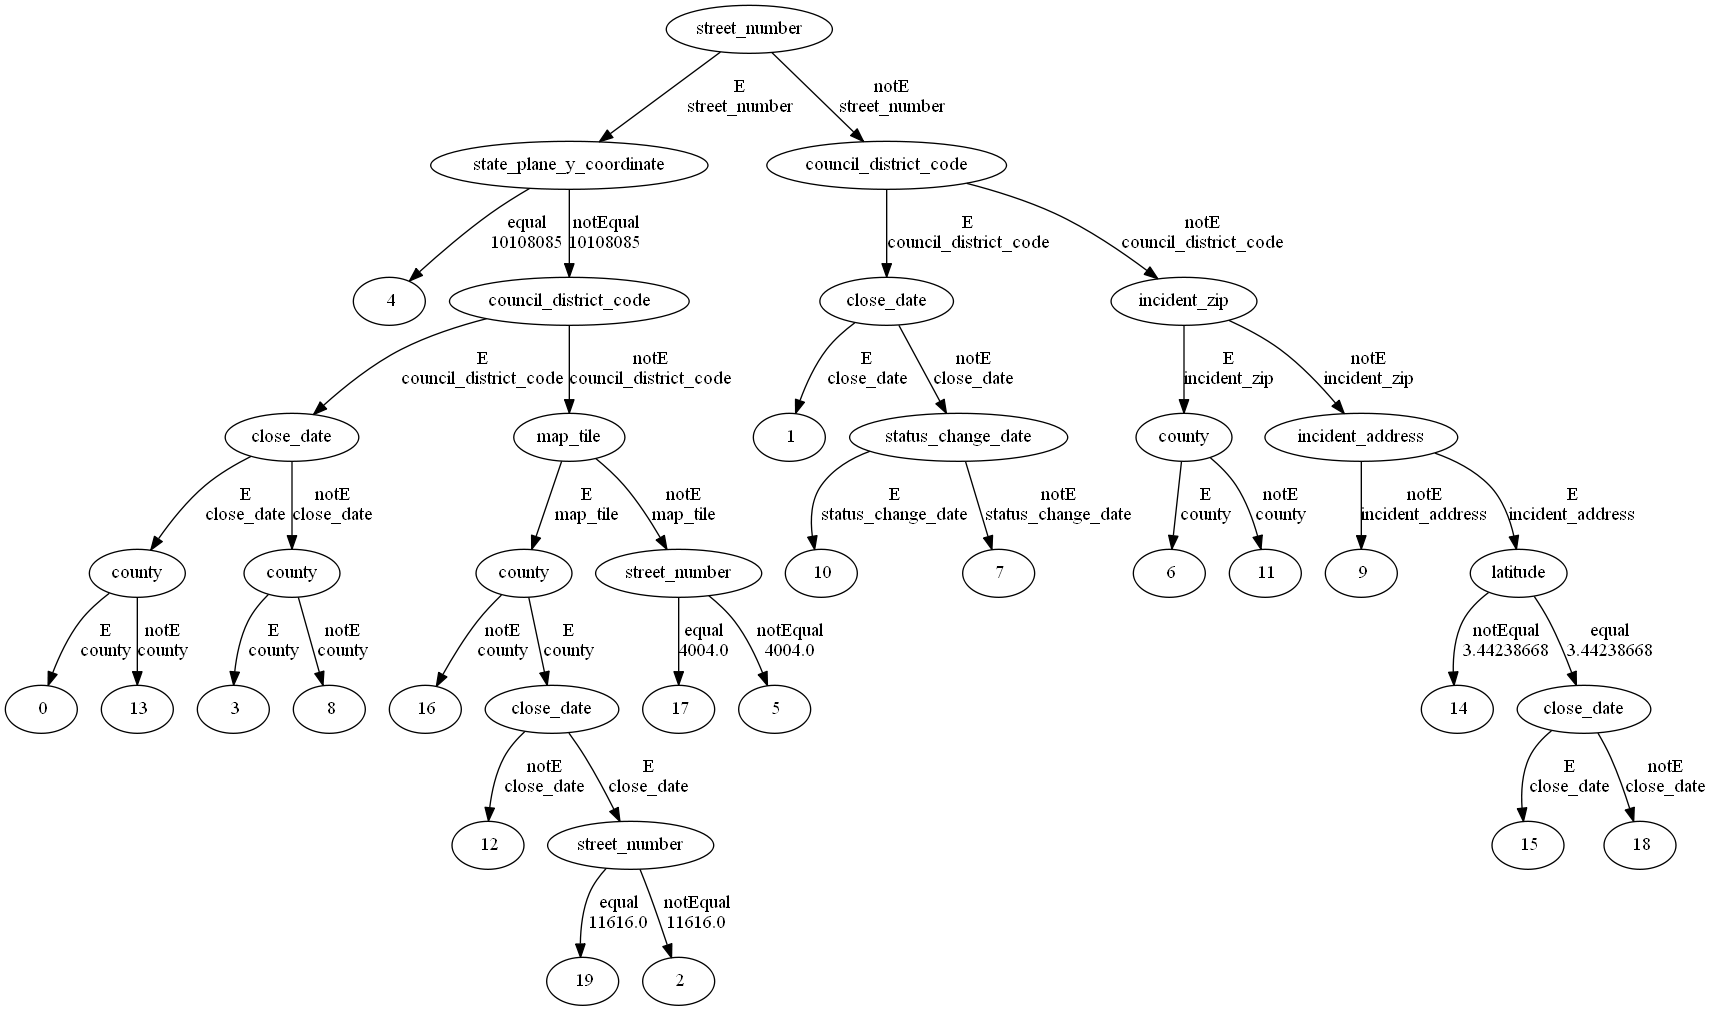

{   0: {   'city': 'str',
           'close_date': 'str',
           'complaint_description': 'str',
           'complaint_type': 'str',
           'council_district_code': 'float',
           'county': 'str',
           'created_date': 'str',
           'incident_address': 'str',
           'incident_zip': 'float',
           'last_update_date': 'str',
           'latitude': 'float',
           'location': 'str',
           'longitude': 'float',
           'map_page': 'str',
           'map_tile': 'str',
           'owning_department': 'str',
           'source': 'str',
           'state_plane_x_coordinate': 'str',
           'state_plane_y_coordinate': 'float',
           'status': 'str',
           'status_change_date': 'str',
           'street_name': 'str',
           'street_number': 'float',
           'unique_key': 'str'},
    1: {   'city': 'str',
           'close_date': 'str',
           'complaint_description': 'str',
           'complaint_type': 'str',
           'council_

            'complaint_type': 'str',
            'created_date': 'str',
            'incident_address': 'str',
            'incident_zip': 'float',
            'last_update_date': 'str',
            'latitude': 'float',
            'location': 'str',
            'longitude': 'float',
            'map_page': 'str',
            'map_tile': 'str',
            'owning_department': 'str',
            'source': 'str',
            'state_plane_x_coordinate': 'str',
            'state_plane_y_coordinate': 'float',
            'status': 'str',
            'status_change_date': 'str',
            'street_name': 'str',
            'unique_key': 'str'},
    12: {   'city': 'str',
            'complaint_description': 'str',
            'complaint_type': 'str',
            'county': 'str',
            'created_date': 'str',
            'incident_address': 'str',
            'incident_zip': 'float',
            'last_update_date': 'str',
            'latitude': 'float',
            'location': 'str',

In [78]:
im = Image(G.create_png())
display(im)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(schemasDict)

In [46]:
idvsnumber = {}
for key, value in sizeOfSchema.items():
    for k,v in schemasDict.items():

        temp = json.loads(key)
        if temp.keys()==v.keys():
            idvsnumber[k]=value
pp.pprint(idvsnumber)

{0: 104, 1: 101, 2: 100, 3: 100}
time: 2 ms


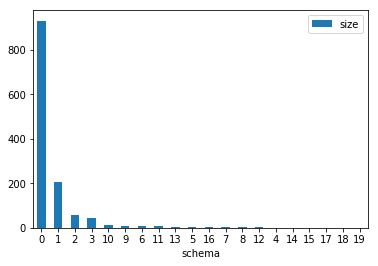

time: 237 ms


In [183]:
a =[]
b = []
for key, value in idvsnumber.items():
    a.append(key)
    b.append(value)

df = pd.DataFrame.from_dict({'schema':a,'size':b})
df = df.sort_values(by=['size'], ascending=False)
bar = df.plot.bar(x='schema', y='size', rot=0)
bar

In [ ]:
def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return input_list[int(middle - .5)]
    else:
        return (input_list[int(middle)], input_list[int(middle-1)])

In [ ]:
attributes = {}
MaxValue = {}
MinValue = {}
MiddleValue = {}
MedianValue = {}
STD = {}
for schema in schemas:
    for key, value in schema.items():
        attributes[key]= value

print(len(attributes))    
for attribute in attributes:
    value = []
    isString = False
    for data in datas:
        temp = getValue(data, attribute.split('.'))
        if  temp is None:
            continue
            
        if type(temp) is str:
            if not temp.isdigit():
                isString = True
                break
        if type(temp) is str:
            if '.' in temp:
                value.append(float(temp))
            else:
                value.append(int(temp))
        else:
            value.append(temp)
    
    if isString:
        continue
    
    value.sort()
    MaxValue[attribute] = value[-1]
    MinValue[attribute] = value[0]
    MiddleValue[attribute] = findMiddle(value)
    MedianValue[attribute] = statistics.median(value)
    if len(value) < 2:
        STD[attribute] = -1
    else:
        STD[attribute] = statistics.stdev(value)
print(MaxValue)
print(MinValue)
print(MiddleValue)
print(MedianValue)
print(STD)

In [78]:
with open('restaurant-2000.json', 'w') as outfile:  
    json.dump(datas, outfile)

time: 162 ms
